# CAB420, Encoders and Decoders, Example 3: Semi-Supervised Learning
Dr Simon Denman (s.denman@qut.edu.au)

## Overview
In this example we will look at how we can use semi-supervised learning to learn from partial data. Semi-supervised learning works best when you have two tasks, and typically these can be divided into:
* One that is easy to annotate, and you have lots of data for;
* One that is harder to annotate, and so you have less samples.

In our case, we'll use an autoencoder as our easy to annotate task (what can be easier than using the same data as the input), and the classification task as our harder to annotate task.

## Too Long; Didn't Read:
* When we use multi-task learning, we don't have to have labels for all tasks for all samples. Instead we can have some (or a lot) of samples for which we have no labels.
* During training, we take note of which training samples we don't have data for and excluded them from the loss calculations. We can do this simply by keeping track of a mask that indicates which samples we do and do not have data for.
* We can also adjust the loss weights to compensate for the lack of data. This means for tasks that we have less data for, we can place a higher weight so that the network still devotes enough energy to that task. We can also use this idea to give tasks different priorities, i.e. some tasks are probably more important than others and the loss weights can reflect that.

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras import regularizers

from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.utils import model_to_dot, plot_model

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

import numpy

from sklearn.manifold import TSNE

## The Data
It's fashion MNIST again!

In [2]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = numpy.reshape(x_train, (len(x_train), 28, 28, 1))
y_train = to_categorical(y_train)
x_test = numpy.reshape(x_test, (len(x_test), 28, 28, 1))
y_test = to_categorical(y_test)

## The Network

We'll use a fairly simple autoencoder, and just have two outputs coming from the encoding.

In [3]:
def build_network():
    input_img = Input(shape=(28, 28, 1))

    x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(4, (3, 3), activation='relu', padding='same')(x)

    # at this point the representation is (4, 4, 4) i.e. 64-dimensional
    encoded = MaxPooling2D((2, 2), padding='same', name='bottleneck')(x)

    # first output, we'll flatten the embedding, and pass it through a couple of dense layers to
    # get our output
    class_out = Flatten()(encoded)
    class_out = Dense(32, activation='relu')(class_out)
    class_out = Dense(10, activation='softmax', name='class_output')(class_out)
    
    # second output, we'll do the usual decode to get our autoencoder output
    x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(16, (3, 3), activation='relu')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same', name='autoenc_output')(x)

    multitask_cnn = Model(input_img, [class_out, decoded])

    return multitask_cnn

## Model 1: All the Data

Let's test that with all the data, just to make sure that it all works before we start shedding data.

Our setup for this is pretty straight forward, we'll:
* Use categorical cross-entropy for our classifier loss
* Use mean squared error for our autoencoder loss

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 28, 28, 16)   160         input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 14, 14, 16)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 14, 14, 8)    1160        max_pooling2d[0][0]              
______________________________________________________________________________________________

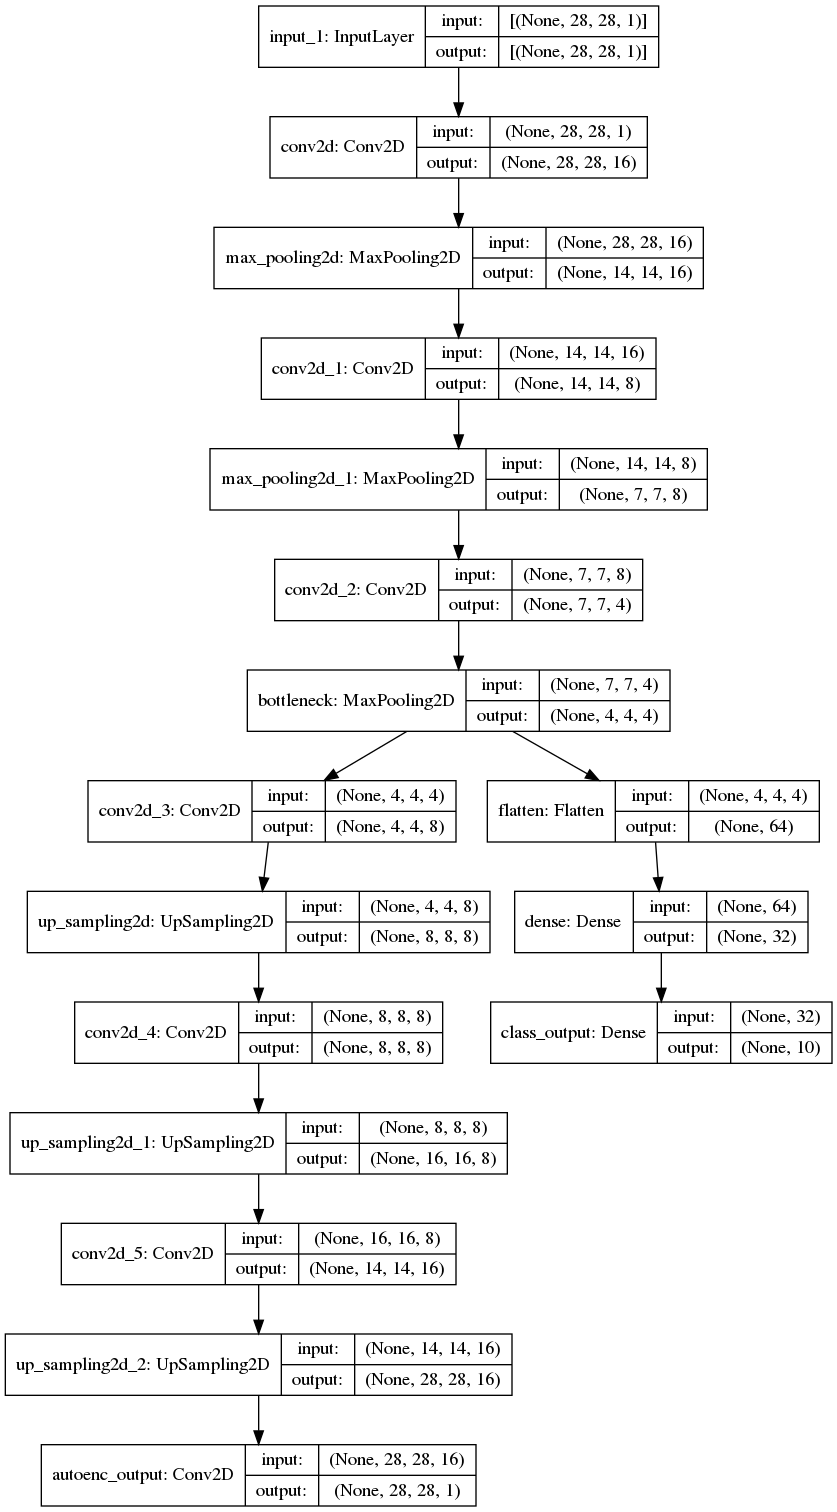

In [4]:
multitask_cnn = build_network()
multitask_cnn.compile(optimizer='adam', loss=['categorical_crossentropy', 'mean_squared_error'])
print(multitask_cnn.summary())
plot_model(multitask_cnn, show_shapes=True)

In [5]:
history = multitask_cnn.fit(x_train, [y_train, x_train],
                    batch_size=64,
                    epochs=10,
                    validation_data=(x_test, [y_test, x_test]))

Epoch 1/10
938/938 [==============================] - 9s 8ms/step - loss: 1.1465 - class_output_loss: 1.0872 - autoenc_output_loss: 0.0593 - val_loss: 0.5715 - val_class_output_loss: 0.5447 - val_autoenc_output_loss: 0.0268
Epoch 2/10
938/938 [==============================] - 7s 8ms/step - loss: 0.5399 - class_output_loss: 0.5136 - autoenc_output_loss: 0.0264 - val_loss: 0.5332 - val_class_output_loss: 0.5085 - val_autoenc_output_loss: 0.0247
Epoch 3/10
938/938 [==============================] - 8s 8ms/step - loss: 0.4807 - class_output_loss: 0.4568 - autoenc_output_loss: 0.0239 - val_loss: 0.4707 - val_class_output_loss: 0.4474 - val_autoenc_output_loss: 0.0233
Epoch 4/10
938/938 [==============================] - 8s 8ms/step - loss: 0.4298 - class_output_loss: 0.4070 - autoenc_output_loss: 0.0227 - val_loss: 0.4335 - val_class_output_loss: 0.4112 - val_autoenc_output_loss: 0.0223
Epoch 5/10
938/938 [==============================] - 7s 8ms/step - loss: 0.4106 - class_output_loss: 0.

              precision    recall  f1-score   support

           0       0.79      0.86      0.83      1000
           1       0.98      0.97      0.97      1000
           2       0.75      0.85      0.80      1000
           3       0.91      0.85      0.88      1000
           4       0.78      0.80      0.79      1000
           5       0.99      0.94      0.96      1000
           6       0.72      0.60      0.66      1000
           7       0.89      0.98      0.94      1000
           8       0.97      0.96      0.97      1000
           9       0.97      0.93      0.95      1000

    accuracy                           0.87     10000
   macro avg       0.88      0.87      0.87     10000
weighted avg       0.88      0.87      0.87     10000



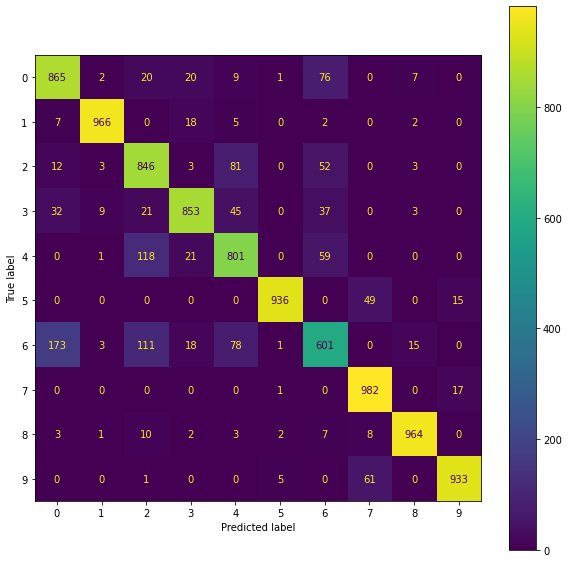

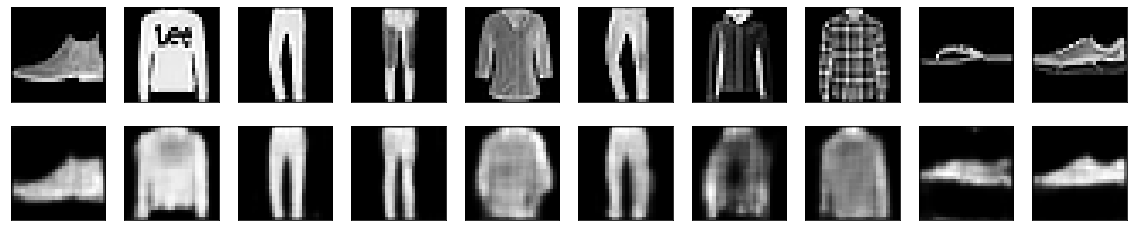

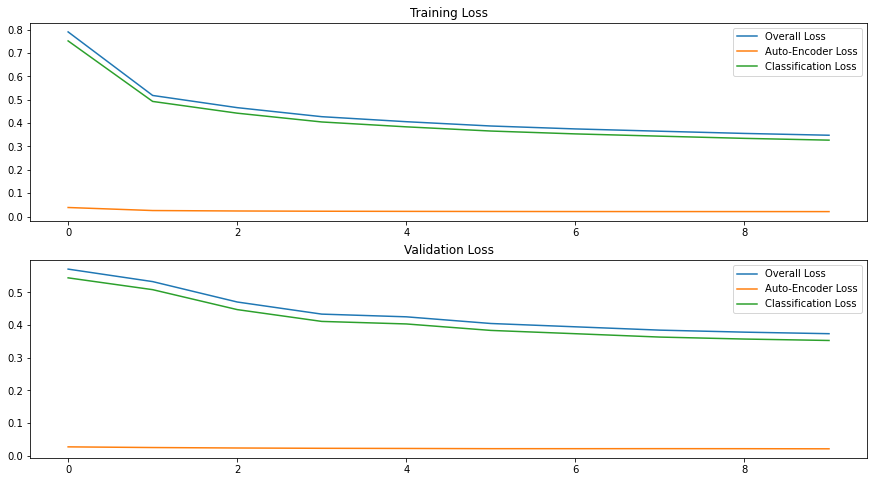

In [6]:
def eval_model(model, x_test, y_test, history):
    predictions, decoded_imgs = model.predict(x_test);

    indexes = tf.argmax(predictions, axis=1)
    gt = tf.argmax(y_test, axis=1)
    
    cm = confusion_matrix(gt, indexes)
    fig = plt.figure(figsize=[10, 10])
    ax = fig.add_subplot(1, 1, 1)
    c = ConfusionMatrixDisplay(cm, display_labels=range(10))
    c.plot(ax = ax)

    print(classification_report(gt, indexes))
    
    n = 10
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # display original
        ax = plt.subplot(2, n, i+1)
        plt.imshow(x_test[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(2, n, i + n + 1)
        plt.imshow(decoded_imgs[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

    fig = plt.figure(figsize=[15, 8])
    ax = fig.add_subplot(2, 1, 1)
    ax.plot(history.history['loss'], label = 'Overall Loss')
    ax.plot(history.history['autoenc_output_loss'], label = 'Auto-Encoder Loss')
    ax.plot(history.history['class_output_loss'], label = 'Classification Loss')
    ax.legend()
    ax.set_title('Training Loss')

    ax = fig.add_subplot(2, 1, 2)
    ax.plot(history.history['val_loss'], label = 'Overall Loss')
    ax.plot(history.history['val_autoenc_output_loss'], label = 'Auto-Encoder Loss')
    ax.plot(history.history['val_class_output_loss'], label = 'Classification Loss')
    ax.legend()
    ax.set_title('Validation Loss')
    
eval_model(multitask_cnn, x_test, y_test, history)

The model works pretty well. Our autoencoder looks about as good as we usually expect, and our classifier is also pretty solid. Overall - the model works.

## Model 2: Using 25% of the Labels

We're now going to remove a bunch of labels. To do this we:
* pick a "mask value", this is what label we will give to missing values, it should be something that otherwise isn't in the labels. We'll pick -1
* We'll randomly remove 75% of the labels, and replace them with this mask value
* We now need a new loss function to use the mask. That loss function will do the standard categorical cross entropy, but we'll first just find any elements that we have no labels for and remove them, so we only calculte the loss on those that we have values for

In [7]:
# set the mask value. This should be something from outside the existing set of labels
mask_value = -1

# select some elements to mask our
mask_idx = numpy.random.choice(len(y_train), int(len(y_train)*0.75), replace=True)
# copy the array. Note that I use .copy() here. By default python does a "soft copy", i.e. it just creates 
# a pointer to the data. I want to keep an original version of the data in y_train, so I'll use .copy() here
# to do a fully copy of the memory
y_train_masked = y_train.copy()
# set my masked values to -1
y_train_masked[mask_idx] = mask_value
# sanity check time - print out the two and see what happened. 75% of my data should be -1
print(y_train)
print(y_train_masked)

# semi-supervised cateogorical cross entropy loss. This wil find any rows that have a -1 in the labels
# and remove them from consideration
def masked_cce(y_true, y_pred):
    y_true_masked = tf.boolean_mask(y_true, tf.reduce_any(tf.not_equal(y_true, -1), 1))
    y_pred_masked = tf.boolean_mask(y_pred, tf.reduce_any(tf.not_equal(y_true, -1), 1))
    return K.mean(K.categorical_crossentropy(y_true_masked, y_pred_masked))

[[0. 0. 0. ... 0. 0. 1.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[-1. -1. -1. ... -1. -1. -1.]
 [ 1.  0.  0. ...  0.  0.  0.]
 [ 1.  0.  0. ...  0.  0.  0.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


Now we can pass our reduced data and new loss function into our model for training

In [8]:
multitask_cnn = build_network()
multitask_cnn.compile(optimizer='adam', loss=[masked_cce, 'mean_squared_error'])

history = multitask_cnn.fit(x_train, [y_train_masked, x_train],
                    batch_size=64,
                    epochs=10,
                    validation_data=(x_test, [y_test, x_test]))

Epoch 1/10
938/938 [==============================] - 6s 6ms/step - loss: 1.2176 - class_output_loss: 1.1563 - autoenc_output_loss: 0.0613 - val_loss: 0.6050 - val_class_output_loss: 0.5790 - val_autoenc_output_loss: 0.0260
Epoch 2/10
938/938 [==============================] - 6s 6ms/step - loss: 0.5246 - class_output_loss: 0.4993 - autoenc_output_loss: 0.0253 - val_loss: 0.5238 - val_class_output_loss: 0.4998 - val_autoenc_output_loss: 0.0240
Epoch 3/10
938/938 [==============================] - 6s 6ms/step - loss: 0.4641 - class_output_loss: 0.4406 - autoenc_output_loss: 0.0235 - val_loss: 0.4929 - val_class_output_loss: 0.4700 - val_autoenc_output_loss: 0.0230
Epoch 4/10
938/938 [==============================] - 7s 7ms/step - loss: 0.4428 - class_output_loss: 0.4200 - autoenc_output_loss: 0.0228 - val_loss: 0.4571 - val_class_output_loss: 0.4347 - val_autoenc_output_loss: 0.0224
Epoch 5/10
938/938 [==============================] - 5s 5ms/step - loss: 0.4132 - class_output_loss: 0.

              precision    recall  f1-score   support

           0       0.75      0.87      0.81      1000
           1       0.99      0.96      0.97      1000
           2       0.75      0.85      0.80      1000
           3       0.87      0.86      0.87      1000
           4       0.78      0.75      0.76      1000
           5       0.97      0.96      0.97      1000
           6       0.69      0.50      0.58      1000
           7       0.92      0.97      0.94      1000
           8       0.92      0.97      0.94      1000
           9       0.97      0.93      0.95      1000

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000



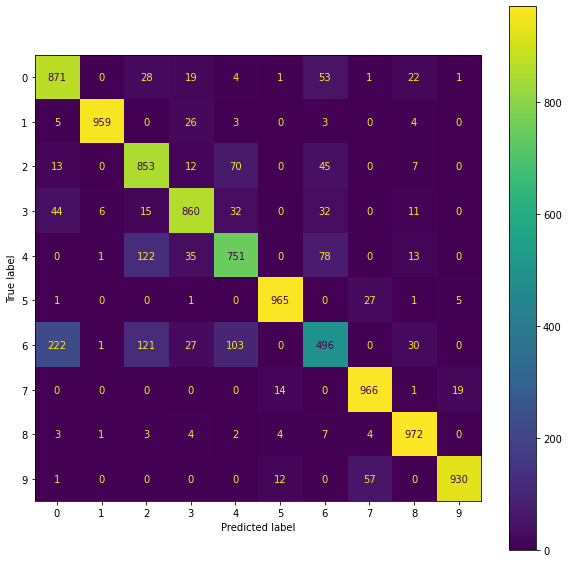

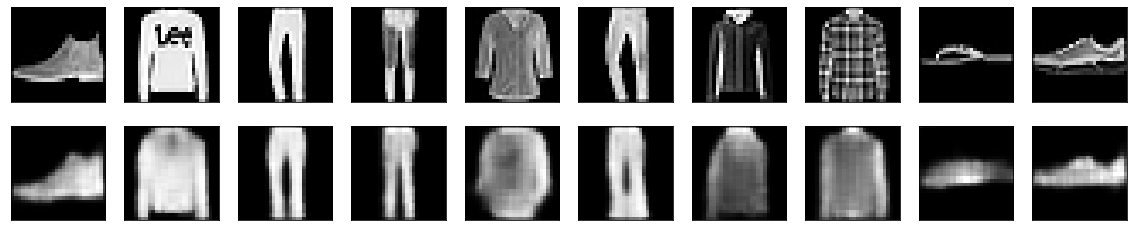

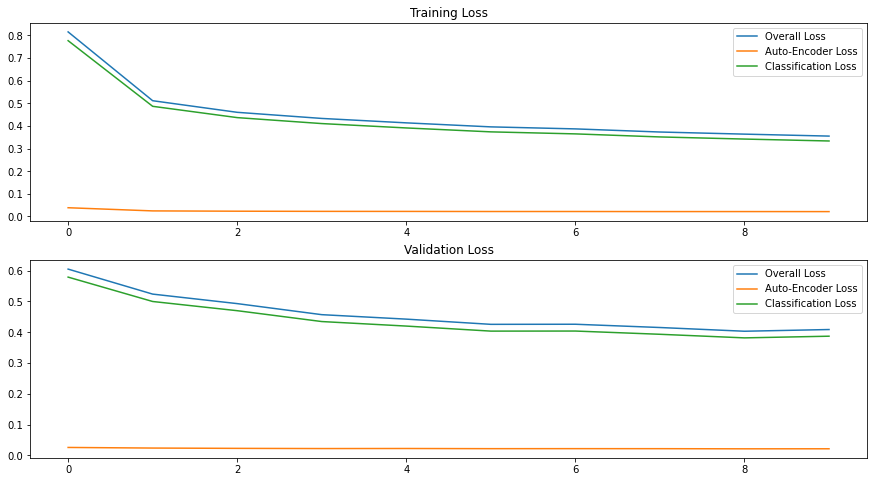

In [9]:
eval_model(multitask_cnn, x_test, y_test, history)

We see performance is still pretty good. Much the same as last time, but now with much less data.

## Model 2: Using 5% of the Labels

We've thrown away a lot of data now, keeping just 5% of the labels.

In [10]:
mask_idx = numpy.random.choice(len(y_train), int(len(y_train)*0.95), replace=True)
y_train_masked = y_train.copy()
y_train_masked[mask_idx] = mask_value

multitask_cnn = build_network()
multitask_cnn.compile(optimizer='adam', loss=[masked_cce, 'mean_squared_error'])

history = multitask_cnn.fit(x_train, [y_train_masked, x_train],
                    batch_size=64,
                    epochs=10,
                    validation_data=(x_test, [y_test, x_test]))

Epoch 1/10
938/938 [==============================] - 6s 6ms/step - loss: 1.2274 - class_output_loss: 1.1689 - autoenc_output_loss: 0.0585 - val_loss: 0.6272 - val_class_output_loss: 0.6017 - val_autoenc_output_loss: 0.0255
Epoch 2/10
938/938 [==============================] - 7s 8ms/step - loss: 0.5822 - class_output_loss: 0.5576 - autoenc_output_loss: 0.0246 - val_loss: 0.5891 - val_class_output_loss: 0.5658 - val_autoenc_output_loss: 0.0233
Epoch 3/10
938/938 [==============================] - 7s 7ms/step - loss: 0.5289 - class_output_loss: 0.5063 - autoenc_output_loss: 0.0225 - val_loss: 0.5214 - val_class_output_loss: 0.4996 - val_autoenc_output_loss: 0.0218
Epoch 4/10
938/938 [==============================] - 5s 5ms/step - loss: 0.4851 - class_output_loss: 0.4635 - autoenc_output_loss: 0.0216 - val_loss: 0.5096 - val_class_output_loss: 0.4886 - val_autoenc_output_loss: 0.0210
Epoch 5/10
938/938 [==============================] - 5s 5ms/step - loss: 0.4615 - class_output_loss: 0.

              precision    recall  f1-score   support

           0       0.74      0.87      0.80      1000
           1       0.99      0.97      0.98      1000
           2       0.78      0.79      0.79      1000
           3       0.89      0.84      0.87      1000
           4       0.77      0.74      0.76      1000
           5       0.98      0.93      0.96      1000
           6       0.63      0.57      0.60      1000
           7       0.92      0.95      0.94      1000
           8       0.95      0.97      0.96      1000
           9       0.94      0.96      0.95      1000

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000



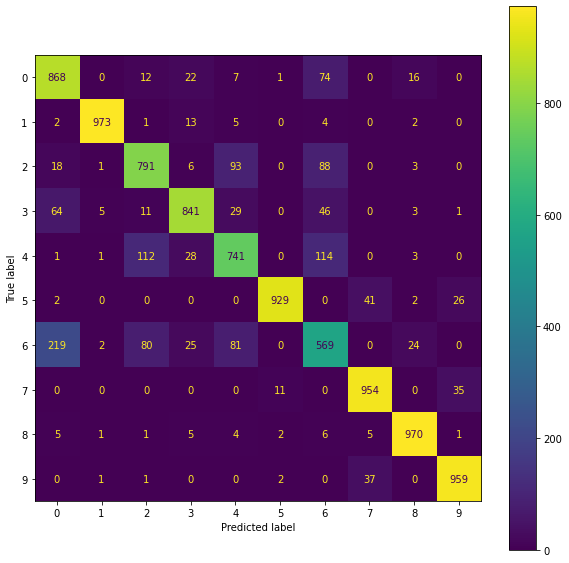

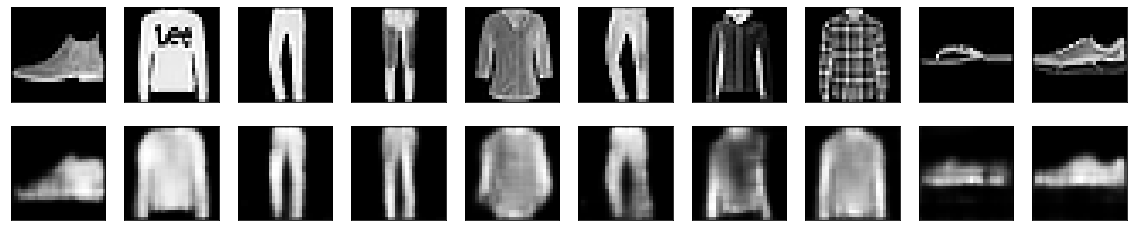

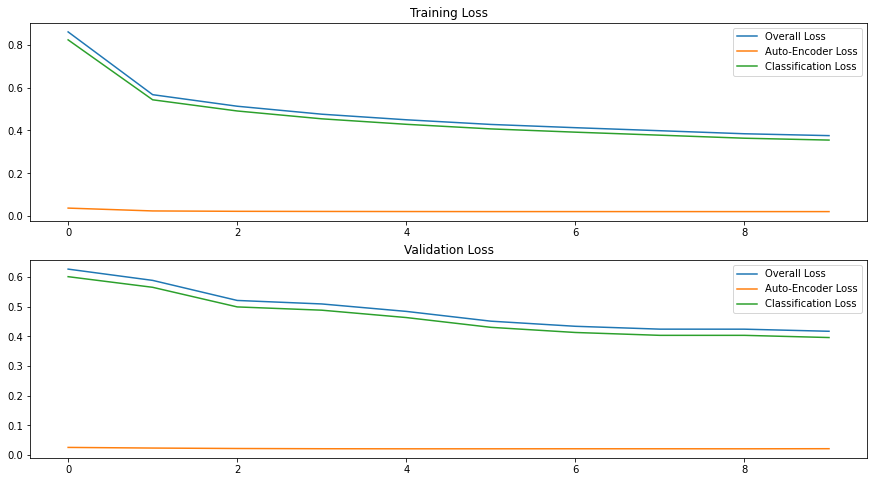

In [11]:
eval_model(multitask_cnn, x_test, y_test, history)

Again, we see the model works pretty well, with no major drop in performance, despite most of the labels now being missig.

### What of Loss Weights?

Loss weights were discussed above, but we haven't used them here yet. Why not? 

The short answer is we don't need to use them here as we reduce the amount of labels due to the way that out losses are worked out. In some toolkits (and MATLAB is one such toolkit), the total loss is the sum of all the individual losses for each sample, i.e. if we have 10 samples in a batch, the loss is the sum across all of those samples). In Keras, it's the mean of the samples in the batch (have a look at our custom loss function above). That doesn't mean that we can't do it though, or even that we shouldn't.

Here, we only really care about our classification task. Our auto-encoder task is really just along for the ride to give us our second task. As such, we'll go again with our classificaiton loss set to be 10 times that of the autoencoder loss.

In [12]:
multitask_cnn = build_network()
multitask_cnn.compile(optimizer='adam', loss=[masked_cce, 'mean_squared_error'], loss_weights=[10, 1])

history = multitask_cnn.fit(x_train, [y_train_masked, x_train],
                    batch_size=64,
                    epochs=10,
                    validation_data=(x_test, [y_test, x_test]))

Epoch 1/10
938/938 [==============================] - 7s 7ms/step - loss: 12.4674 - class_output_loss: 1.2404 - autoenc_output_loss: 0.0639 - val_loss: 6.4299 - val_class_output_loss: 0.6403 - val_autoenc_output_loss: 0.0273
Epoch 2/10
938/938 [==============================] - 6s 6ms/step - loss: 5.8352 - class_output_loss: 0.5809 - autoenc_output_loss: 0.0262 - val_loss: 5.6740 - val_class_output_loss: 0.5650 - val_autoenc_output_loss: 0.0242
Epoch 3/10
938/938 [==============================] - 6s 6ms/step - loss: 4.8957 - class_output_loss: 0.4872 - autoenc_output_loss: 0.0236 - val_loss: 4.7587 - val_class_output_loss: 0.4736 - val_autoenc_output_loss: 0.0229
Epoch 4/10
938/938 [==============================] - 8s 8ms/step - loss: 4.4751 - class_output_loss: 0.4452 - autoenc_output_loss: 0.0227 - val_loss: 4.6689 - val_class_output_loss: 0.4647 - val_autoenc_output_loss: 0.0222
Epoch 5/10
938/938 [==============================] - 5s 5ms/step - loss: 4.1823 - class_output_loss: 0

When we look at the output from this, we see that the total loss is now the sum of class_output_loss x 10 + autoenc_output_loss. The individual losses are shown as they were before, just the combined loss is changed. 

We see our auto-encoder is now slightly less accurate, as the model places greater priority on the class_output_loss and getting that as low as possible.

              precision    recall  f1-score   support

           0       0.79      0.84      0.82      1000
           1       0.96      0.97      0.97      1000
           2       0.72      0.84      0.77      1000
           3       0.90      0.81      0.85      1000
           4       0.70      0.83      0.76      1000
           5       0.99      0.93      0.96      1000
           6       0.75      0.48      0.59      1000
           7       0.93      0.94      0.93      1000
           8       0.95      0.98      0.96      1000
           9       0.92      0.96      0.94      1000

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000



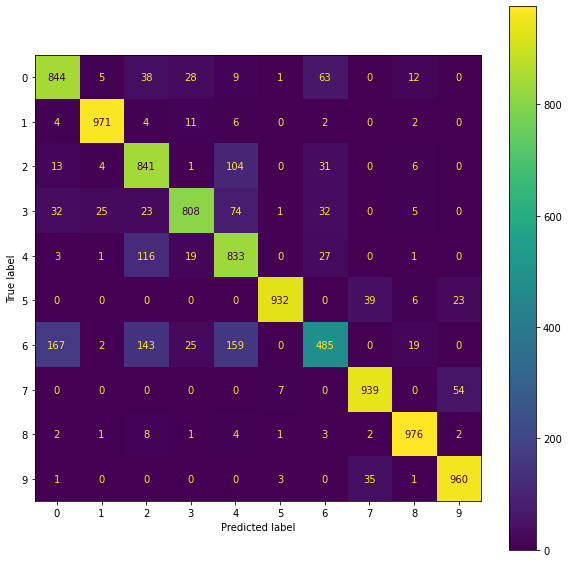

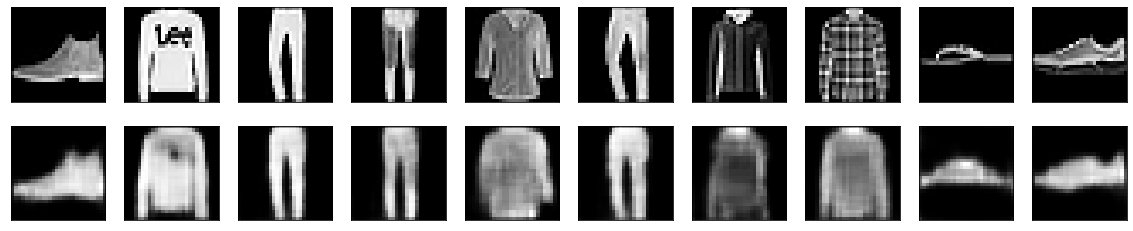

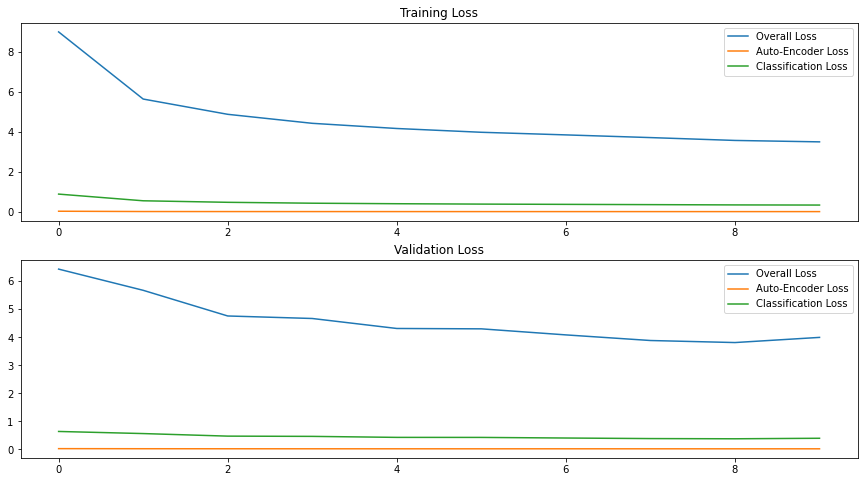

In [13]:
eval_model(multitask_cnn, x_test, y_test, history)

## What is Learnt?

We've visualised the embedding in a autoencoder before and it often doesn't show the nice class separation that we expect. What about this time?

In [14]:
bottleneck_output = multitask_cnn.get_layer('bottleneck').output 
bottleneck_model = Model(inputs = multitask_cnn.input, outputs = bottleneck_output)
bottleneck_prediction = bottleneck_model.predict(x_test)

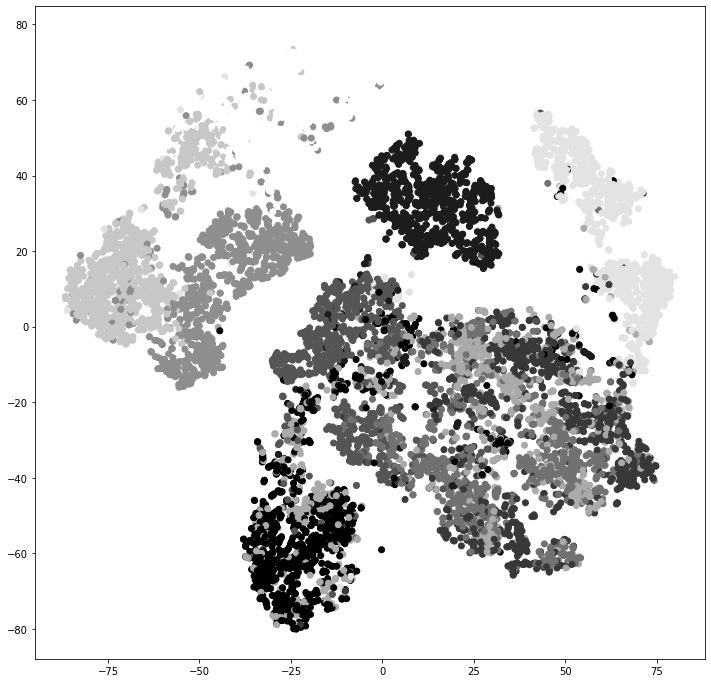

In [15]:
tsne_embeddings = TSNE(random_state=4).fit_transform(numpy.reshape(bottleneck_prediction, (-1, 64)))
fig = plt.figure(figsize=[12, 12])
ax = fig.add_subplot(1, 1, 1)
ax.scatter(tsne_embeddings[:,0], tsne_embeddings[:,1], c = tf.argmax(y_test, axis=1));

This is looking a little better, though still not perfect. There's a couple of reasons why our separation may not be as good as we expect here:
* We have two tasks, only one of them is classification, which is the one that will drive the separation of classes in the embedding space.
* We have very limited data for the classification task, which will inhibit it's ability to learn a good class separation.

## Final Thoughts

In this example we've seen how we can use semi-supervised learning to learn from very limited data. We've also done this using an auto-encoder. As this is itself an unsupervised model, we can see how to learn things from very small amounts of labels.

The trick to all of this is a mask input that allows to basically ignore outputs that we don't have ground truth for. This way we only calculate the loss for the samples that we actually know. We can also change the weights of our losses to compensate for the fact that we have limited ground truth.

To do this however, we need to write a custom loss function that can exclude samples that don't have labels from consideration.